<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/catagotical%20prediction%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import tracemalloc
from scipy.stats import norm
from statistics import NormalDist

import tensorflow_probability as tfp

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Concatenate, GaussianNoise
from tensorflow.keras.regularizers import l2


### <font color='purple'><center>**-------------------Create Data-------------------**</font>

In [4]:
end_date = datetime.now() - timedelta(days=1)
start_date = end_date - timedelta(days=728)

tickers = [
    'EURUSD=X', 'USDEUR=X',  # Euro/US Dollar
    'USDJPY=X', 'JPYUSD=X',  # US Dollar/Japanese Yen
    'GBPUSD=X', 'USDGBP=X',  # British Pound/US Dollar
    'USDCHF=X', 'CHFUSD=X',  # US Dollar/Swiss Franc
    'AUDUSD=X', 'USDAUD=X',  # Australian Dollar/US Dollar
    'USDCAD=X', 'CADUSD=X',  # US Dollar/Canadian Dollar
    'NZDUSD=X', 'USDNZD=X',  # New Zealand Dollar/US Dollar
]

data_list = []
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
    data_list.append(data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
def create_data(raw_data, window_size):
    High = raw_data['High'].to_numpy()
    Close = raw_data['Close'].to_numpy()
    Low = raw_data['Low'].to_numpy()
    Std = np.std(np.diff(Close))
    Close_Diff = np.diff(Close)/Std
    High_Adj = (High[1:]-Close[1:])/Std
    Low_Adj = (Close[1:]-Low[1:])/Std

    stack = np.stack((Close_Diff, High_Adj, Low_Adj), axis=1)

    window_view = np.lib.stride_tricks.sliding_window_view(stack, (window_size,),axis=0)

    Forex_Data = window_view[:-1]
    Forex_Data = Forex_Data.astype('float32')
    target = Close_Diff[window_size:]

    return Forex_Data, target


In [6]:
window_list = []
target_list = []
for data in data_list:
    window, target =  create_data(data, 50)
    window_list.append(window)
    target_list.append(target)


In [13]:
print(target_list)

[array([-0.1025164 ,  0.20512808,  0.10261168, ...,  0.0963235 ,
        0.19274227,  0.19283755]), array([ 0.08803974, -0.17613199, -0.08809224, ..., -0.08809224,
       -0.17613199, -0.17618448]), array([-0.07970181,  0.14347137, -0.30287499, ...,  0.36129325,
       -0.15405233, -0.31880724]), array([ 0.11318718, -0.20375531,  0.43031356, ..., -0.32429828,
        0.13824283,  0.28627805]), array([ 0.26664414,  0.01068274, -0.08532046, ..., -0.45178813,
        0.1056955 ,  0.45192962]), array([-0.21026127, -0.00842248,  0.0672796 , ...,  0.39530523,
       -0.09249691, -0.39535536]), array([-0.32700512,  0.8084173 , -0.47231667, ..., -0.66305161,
       -0.11813331,  0.19078908]), array([ 0.34197483, -0.84493501,  0.49343443, ...,  0.7865421 ,
        0.1402192 , -0.2265226 ]), array([-0.29753957,  0.19989552, -0.72608537, ...,  0.04674036,
        0.23420139,  0.14910285]), array([ 0.26041554, -0.17501838,  0.63610198, ..., -0.04692264,
       -0.23481675, -0.14941959]), array([-0

In [7]:
# Assume data is your numpy array and bins is a numpy array defining your bins
data = target_list[0]
input_data = window_list[0]
for i in range(len(target_list)-1):

  data = np.append(data,target_list[i+1])
  input_data = np.append(input_data, window_list[i+1],axis=0)


In [27]:
print(data)

[-0.1025164   0.20512808  0.10261168 ...  0.11633887  0.
 -0.62062808]


In [8]:
espi = .000001
min = np.min(data)-espi
max = np.max(data)+espi

large = np.max((np.abs(min),np.abs(max)))

data2 = data/large*.5
data2 = data2+.5

stdddd = np.std(data2)
meanie = np.mean(data2)

inverse_transformed_array = norm.cdf(data2, loc=.5, scale=stdddd*1.5)

inverse_transformed_array = (inverse_transformed_array-.5)#*(large/.5)



True


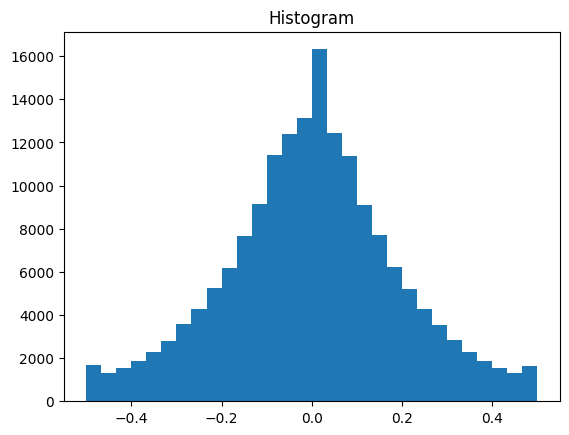

In [9]:
def check_signs(arr1, arr2):
  return np.all(np.sign(arr1) == np.sign(arr2))

print(check_signs(inverse_transformed_array,data))
plt.hist(inverse_transformed_array, bins=30)
plt.title("Histogram")
plt.show()

In [10]:

bin_num = 51
space = .5
bins = np.linspace(-space, space, bin_num-1)
digitized = np.digitize(inverse_transformed_array, bins, right=False)
digitized = tf.keras.utils.to_categorical(digitized)
shape = digitized.shape[1]

In [43]:
def convert_list(lst):
   return [1 if x > 0 else 0 for x in lst]
new_data = convert_list(data)
digitized = tf.keras.utils.to_categorical(new_data)

print(data)
print(digitized)

[-0.1025164   0.20512808  0.10261168 ...  0.11633887  0.
 -0.62062808]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [29]:
print(input_data.shape)
data2 = np.transpose(input_data, (0, 2, 1))
print(data2.shape)

(172230, 3, 50)
(172230, 50, 3)


In [ ]:
from keras.optimizers import Adam

from keras.layers import Conv1D, Flatten , Conv2D

Drop_val = .5
# Initialize the model
model = Sequential()

# Add the first Conv1D layer
model.add(Conv1D(32, kernel_size=3,strides = 2, activation='relu'))

model.add(BatchNormalization())

# Add the second Conv1D layer
model.add(Conv1D(64, kernel_size=3,strides = 2, activation='relu'))

model.add(BatchNormalization())

# Add the second Conv1D layer
model.add(Conv1D(128, kernel_size=3,strides = 2, activation='relu'))

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(100,activation='gelu'))

model.add(BatchNormalization())

model.add(Dropout(Drop_val))

model.add(Dense(50,activation='gelu'))

model.add(BatchNormalization())

model.add(Dropout(Drop_val))

# Add the Dense layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



In [ ]:
# Train the model
model.fit(data2, digitized, epochs=200, batch_size=32,validation_split=.2)


Epoch 1/200
1348/4306 [========>.....................] - ETA: 25s - loss: 0.6337 - accuracy: 0.6405

In [49]:
pred = model.predict(data2)
num = 50

5383/5383 [==============================] - 16s 3ms/step


0.5113434392584354


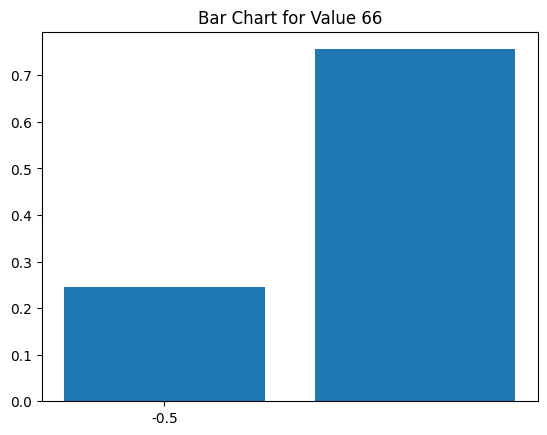

0.10232585313276685


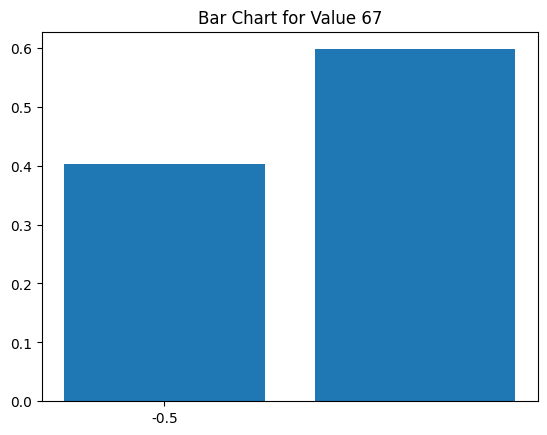

-0.4092081370626011


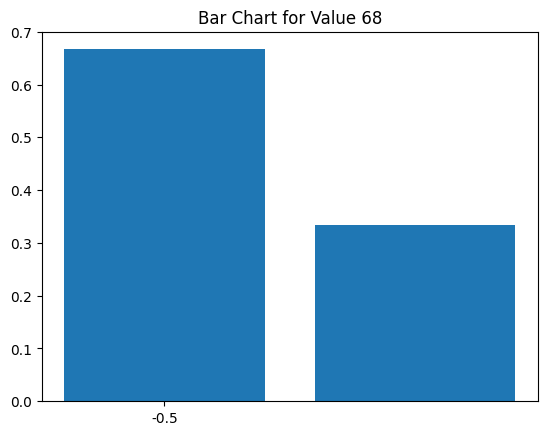

0.4092081370626011


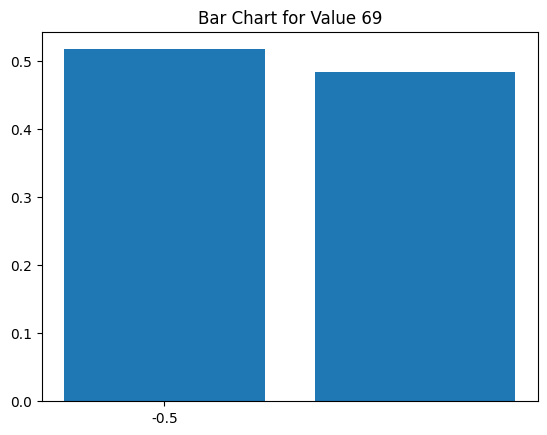

-0.2046517062655337


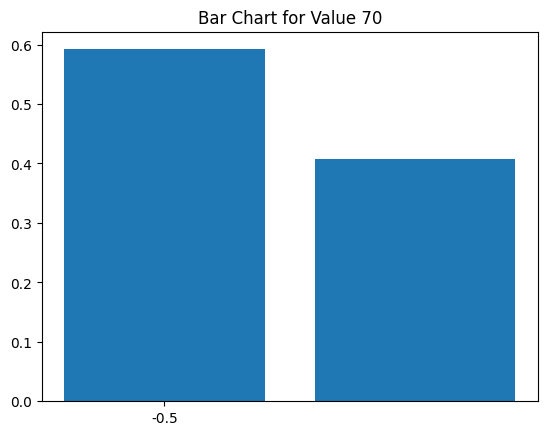

In [53]:
shape = 2
for i in range(5):
   num += 1
   dist = pred[num]

   val = target_list[0][num]

   values = np.linspace(-space, space, 2)

   #round the numbers to one decimal place and only include every other value
   values2 = [round(value, shape) for value in values[::5]]

   bin_centers = (values[:-1] + values[1:]) / 2
   dist2 = dist[:len(bin_centers)]

   # Calculate the mean of the distribution
   mean = np.sum(dist2 * bin_centers)

  # print(mean)
  # print(shape)
   print(val)

   # Create a new figure for each bar chart
   plt.figure()

   plt.bar(range(shape), dist)
   plt.xticks(range(len(dist))[::5], values2)
   plt.title(f'Bar Chart for Value {num}')
   plt.show()

